In [3]:
import math
import zipfile
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
def get_hour(date):
    return date.hour

In [5]:
def get_decimal(number):
    dec, int = math.modf(number)
    return dec


In [6]:
train_data = pd.read_csv('train.csv')

In [7]:
test_data = pd.read_csv('test.csv')

# Data Visualization

In [19]:
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import FastMarkerCluster
from folium.plugins import MarkerCluster


In [20]:
data_vis=pd.read_csv('train.csv',parse_dates=['Dates']) #speacially for visualization so that it doesn't affect my Model train data

In [21]:
data_vis['Year']=data_vis['Dates'].dt.year
data_vis['Month']=data_vis['Dates'].dt.month
data_vis['Hour']=data_vis['Dates'].dt.hour

In [22]:
def street_addr(x):
    street=x.split(' ')
    return (' '.join(street[-2:]))

In [23]:
data_vis['addr']=data_vis['Address'].apply(lambda x:street_addr(x))
data_vis['addr'].tail()

878044    CAPITOL AV
878045       EDNA ST
878046     FOLSOM ST
878047        2ND ST
878048    NEWCOMB AV
Name: addr, dtype: object

In [24]:
commo_crime=data_vis['Category'].value_counts().sort_values(ascending=False).reset_index().head(10)
commo_crime.columns=['Crime','Count']
data = [go.Bar(
            x=commo_crime.Crime,
            y=commo_crime.Count,
             opacity=0.6
    )]

layout = go.Layout(title=' Most Common Crimes ')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

In [25]:
commo_dis=data_vis['PdDistrict'].value_counts().sort_values(ascending=False).reset_index().head(10)
commo_dis.columns=['District','Count']
data = [go.Bar(
            y=commo_dis.District,
            x=commo_dis.Count,
             opacity=0.6,
             orientation = 'h'
    )]
layout = go.Layout(title=' Districts most vulnerable to a Crime ')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar district vulnerable crime')

In [26]:
year_count=data_vis['Year'].value_counts().reset_index().sort_values(by='index')
year_count.columns=['Year','Count']
# Create a trace
trace = go.Scatter(
    x = year_count.Year,
    y = year_count.Count
)

data = [trace]
layout = go.Layout(title=' Crime occured over the years')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-line crime over years')

In [27]:
year_count=data_vis['addr'].value_counts().reset_index().sort_values(by='index').head(10)
year_count.columns=['addr','Count']
# Create a trace
tag = (np.array(year_count.addr))
sizes = (np.array((year_count['Count'] / year_count['Count'].sum())*100))
plt.figure(figsize=(15,8))

trace = go.Pie(labels=tag, values=sizes)
layout = go.Layout(title='Top Address with Most Crimes')
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="top adress with most crimes")

<Figure size 1080x576 with 0 Axes>

In [28]:
data_vis['Year'].max()

2015

In [29]:
data_vis['Year'].min()

2003

In [30]:
data=[]
for i in range(2003,2015):
    year=data_vis[data_vis['Year']==i]
    year_count=year['Month'].value_counts().reset_index().sort_values(by='index')
    year_count.columns=['Month','Count']
    trace = go.Scatter(
    x = year_count.Month,
    y = year_count.Count,
    name = i)
    data.append(trace)
layout = go.Layout(title='Crime of every month for all the years')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-line')

In [31]:
val=data_vis['PdDistrict'].value_counts().reset_index()
val.columns=['District','Count']
x=val.District
data=[]
for i in x:
    district=data_vis[data_vis['PdDistrict']==i]
    year_count=district['Year'].value_counts().reset_index().sort_values(by='index')
    year_count.columns=['Year','Count']
    trace = go.Scatter(
    x = year_count.Year,
    y = year_count.Count,
    name = i)
    data.append(trace)
layout = go.Layout(title='Crime of every month for all the years')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-line crime every month')

# Criminal Activities in Map

In [32]:
mapx = folium.Map(
    location=[data_vis.Y.mean(), data_vis.X.mean()],
    tiles='Cartodb Positron',
    zoom_start=13
)

marker_cluster = MarkerCluster(
    name='Crime Locations',
    overlay=True,
    control=False,
    icon_create_function=None
)
for k in range(1000):
    location = data_vis.Y.values[k], data_vis.X.values[k]
    marker = folium.Marker(location=location,icon=folium.Icon(color='green'))
    popup = data_vis.addr.values[k]
    folium.Popup(popup).add_to(marker)
    marker_cluster.add_child(marker)

marker_cluster.add_to(mapx)

folium.LayerControl().add_to(mapx)

mapx.save("marker cluster south asia.html")

In [33]:
mapx

In [34]:
mapx2= folium.Map(location=[data_vis.Y.mean(), data_vis.X.mean() ],tiles= "Stamen Terrain",
                    zoom_start = 13) 

heat_data = [[[row['Y'],row['X']] 
                for index, row in data_vis.head(1000).iterrows()] 
                 for i in range(0,11)]

hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=1.0)
hm.add_to(mapx2)

hm.save('world MPI heatmap.html')



In [35]:
mapx2

# Location Of the top crimes

In [36]:
top_crime=data_vis['Category'].value_counts().reset_index().head(3)
top_crime

index  Category
0   LARCENY/THEFT    174900
1  OTHER OFFENSES    126182
2    NON-CRIMINAL     92304

# Locations of the First top crime

In [37]:
cat='LARCENY/THEFT'
new=data_vis[data_vis['Category']==cat]
mapx3 = folium.Map(
    location=[data_vis.Y.mean(), data_vis.X.mean()],
    tiles='Cartodb Positron',
    zoom_start=13
)

marker_cluster = MarkerCluster(
    name='Crime Locations',
    overlay=True,
    control=False,
    icon_create_function=None
)
for k in range(1000):
    location = new.Y.values[k], new.X.values[k]
    marker = folium.Marker(location=location,icon=folium.Icon(color='green'))
    popup = new.addr.values[k]
    folium.Popup(popup).add_to(marker)
    marker_cluster.add_child(marker)

marker_cluster.add_to(mapx3)

folium.LayerControl().add_to(mapx3)

mapx3.save("marker cluster south asia.html")


In [38]:
mapx3

In [39]:
new=data_vis[data_vis['Category']=='LARCENY/THEFT']
hmap1= folium.Map(location=[data_vis.Y.mean(), data_vis.X.mean() ],tiles= "Stamen Terrain",
                    zoom_start = 13) 

heat_data = [[[row['Y'],row['X']] 
                for index, row in new.head(1000).iterrows()] 
                 for i in range(0,11)]

hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(hmap1)

hm.save('SanFran Theft heatmap.html')

hmap1

# second top Crime locations


In [40]:
cat='OTHER OFFENSES'
new=data_vis[data_vis['Category']==cat]
mapx4 = folium.Map(
    location=[data_vis.Y.mean(), data_vis.X.mean()],
    tiles='Cartodb Positron',
    zoom_start=13
)

marker_cluster = MarkerCluster(
    name='Crime Locations',
    overlay=True,
    control=False,
    icon_create_function=None
)
for k in range(1000):
    location = new.Y.values[k], new.X.values[k]
    marker = folium.Marker(location=location,icon=folium.Icon(color='green'))
    popup = new.addr.values[k]
    folium.Popup(popup).add_to(marker)
    marker_cluster.add_child(marker)

marker_cluster.add_to(mapx4)

folium.LayerControl().add_to(mapx4)

mapx4.save("marker cluster south asia.html")


In [41]:
mapx4

In [42]:
new=data_vis[data_vis['Category']=='OTHER OFFENSES']
hmap2= folium.Map(location=[data_vis.Y.mean(), data_vis.X.mean() ],tiles= "Stamen Terrain",
                    zoom_start = 13) 

heat_data = [[[row['Y'],row['X']] 
                for index, row in new.head(1000).iterrows()] 
                 for i in range(0,11)]

hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(hmap2)

hm.save('SanFran other offenses.html')

hmap2

# Third top crime


In [43]:
cat='NON-CRIMINAL'
new=data_vis[data_vis['Category']==cat]
mapx5 = folium.Map(
    location=[data_vis.Y.mean(), data_vis.X.mean()],
    tiles='Cartodb Positron',
    zoom_start=13
)

marker_cluster = MarkerCluster(
    name='Crime Locations',
    overlay=True,
    control=False,
    icon_create_function=None
)
for k in range(1000):
    location = new.Y.values[k], new.X.values[k]
    marker = folium.Marker(location=location,icon=folium.Icon(color='green'))
    popup = new.addr.values[k]
    folium.Popup(popup).add_to(marker)
    marker_cluster.add_child(marker)

marker_cluster.add_to(mapx5)

folium.LayerControl().add_to(mapx5)

mapx5.save("marker cluster Non-Criminal.html")


In [44]:
mapx5


In [45]:
new=data_vis[data_vis['Category']=='NON-CRIMINAL']
hmap3= folium.Map(location=[data_vis.Y.mean(), data_vis.X.mean() ],tiles= "Stamen Terrain",
                    zoom_start = 13) 

heat_data = [[[row['Y'],row['X']] 
                for index, row in new.head(1000).iterrows()] 
                 for i in range(0,11)]

hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(hmap3)

hm.save('SanFran other NonCriminal.html')

hmap3

# algorithms

In [47]:
train_data.describe(include='all')

Dates  Category                      Descript DayOfWeek  \
count   878049.000000  878049.0                        878049    878049   
unique            NaN      39.0                           879         7   
top               NaN      16.0  GRAND THEFT FROM LOCKED AUTO    Friday   
freq              NaN  174900.0                         60022    133734   
mean        10.951867       NaN                           NaN       NaN   
std          7.792016       NaN                           NaN       NaN   
min          0.000000       NaN                           NaN       NaN   
25%          2.000000       NaN                           NaN       NaN   
50%         12.000000       NaN                           NaN       NaN   
75%         18.000000       NaN                           NaN       NaN   
max         23.000000       NaN                           NaN       NaN   

           PdDistrict Resolution                 Address              X  \
count   878049.000000     878049                  878049  878049.000000   
unique            NaN         17                   23228            NaN   
top               NaN       NONE  800 Block of BRYANT ST            NaN   
freq              NaN     526790                   26533            NaN   
mean         4.445310        NaN                     NaN      -0.422769   
std          2.863715        NaN                     NaN       0.025293   
min          0.000000        NaN                     NaN      -0.513642   
25%          2.000000        NaN                     NaN      -0.432952   
50%          4.000000        NaN                     NaN      -0.416422   
75%          7.000000        NaN                     NaN      -0.406959   
max          9.000000        NaN                     NaN      -0.364937   

                    Y  
count   878049.000000  
unique            NaN  
top               NaN  
freq              NaN  
mean         0.766976  
std          0.025075  
min          0.000000  
25%          0.752424  
50%          0.775421  
75%          0.784368  
max          0.819975

In [46]:
train_data.describe().transpose()

count       mean       std       min       25%        50%  \
Dates       878049.0  10.951867  7.792016  0.000000  2.000000  12.000000   
PdDistrict  878049.0   4.445310  2.863715  0.000000  2.000000   4.000000   
X           878049.0  -0.422769  0.025293 -0.513642 -0.432952  -0.416422   
Y           878049.0   0.766976  0.025075  0.000000  0.752424   0.775421   

                  75%        max  
Dates       18.000000  23.000000  
PdDistrict   7.000000   9.000000  
X           -0.406959  -0.364937  
Y            0.784368   0.819975

In [48]:
train_data['Dates'] = pd.to_datetime(train_data['Dates'])

train_data['Dates'] = train_data['Dates'].apply(get_hour)
train_data['X'] = train_data['X'].apply(get_decimal)
train_data['Y'] = train_data['Y'].apply(get_decimal)
train_data['PdDistrict'] = train_data['PdDistrict'].astype('category')
cat_columns = train_data.select_dtypes(['category']).columns
train_data[cat_columns] = train_data[cat_columns].apply(lambda x: x.cat.codes)
train_data['Category'] = train_data['Category'].astype('category')


AttributeError: 'int' object has no attribute 'hour'

In [50]:
cat_columns = train_data.select_dtypes(['category']).columns
train_data[cat_columns] = train_data[cat_columns].apply(lambda x: x.cat.codes)
train_data['Category'] = train_data['Category'].astype('category')


In [51]:
test_data['Dates'] = pd.to_datetime(test_data['Dates'])

In [52]:
test_data['Dates'] = test_data['Dates'].apply(get_hour)
test_data['X'] = test_data['X'].apply(get_decimal)
test_data['Y'] = test_data['Y'].apply(get_decimal)
test_data['PdDistrict'] = test_data['PdDistrict'].astype('category')
cat_columns = test_data.select_dtypes(['category']).columns
test_data[cat_columns] = test_data[cat_columns].apply(lambda x: x.cat.codes)

In [53]:
for category in train_data['Category'].unique():
    expression = train_data['Category'] == category
    std = train_data['Dates'][expression].std()
    if std > 6.9:
        train_data['Dates'][expression] = 0
    remove_outlier = (train_data['Dates'][expression] < (2 * std)) & (train_data['Dates'][expression] > (-2 * std))
    train_data['Dates'][expression][~remove_outlier] = 0

In [62]:
labels = train_data["Category"].values
features = train_data[['Dates', u'PdDistrict', u'X', u'Y']].values
classifier = KNeighborsClassifier(n_neighbors=40) # increase the value
classifier = Pipeline([('norm', StandardScaler()), ('knn', classifier)])

In [63]:
import seaborn as sns
from sklearn.model_selection import train_test_split

In [64]:
label = train_data["Category"]
feature = train_data[['Dates', u'PdDistrict', u'X', u'Y']]
train, test,train_labels, test_labels = train_test_split(feature, label, train_size=0.8, random_state=39)

G:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.



# KNN

In [65]:
classifier.fit(train, train_labels)

G:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning:

Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.

G:\Anaconda\lib\site-packages\sklearn\base.py:467: DataConversionWarning:

Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.



Pipeline(memory=None,
     steps=[('norm', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=40, p=2,
           weights='uniform'))])

In [66]:
result = classifier.predict(test)

G:\Anaconda\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning:

Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.



In [67]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [68]:
print("Classification Report")
print(classification_report(result, test_labels))

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.20      0.01         5
           1       0.22      0.17      0.19     20305
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.06      0.14      0.08      2931
           5       0.03      0.17      0.05       140
           6       0.00      0.00      0.00         0
           7       0.41      0.30      0.35     14844
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.05      0.21      0.08       500
          13       0.01      0.20      0.01       112
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.65      0.32      0.43     69392
     

G:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.

G:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.

G:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.



In [69]:
accuracy_score(result,test_labels)

0.27447184101133193

# Random Forest

In [70]:
from sklearn.ensemble import RandomForestClassifier

In [71]:
rfc = RandomForestClassifier(n_estimators = 2, n_jobs=1, criterion="gini") # change n estimator to 100 or 90 or 80 >50
rfc.fit(train, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [72]:
resultrfc= rfc.predict(test)

In [73]:
print("Classification Report")
print(classification_report(resultrfc, test_labels))

Classification Report


G:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.

G:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.



              precision    recall  f1-score   support

           0       0.01      0.05      0.02        73
           1       0.21      0.18      0.19     17917
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.10      0.15      0.12      4836
           5       0.02      0.12      0.03       112
           6       0.00      0.02      0.01        85
           7       0.45      0.29      0.36     16814
           8       0.00      0.00      0.00        65
           9       0.00      0.00      0.00        31
          10       0.00      0.00      0.00        13
          11       0.00      0.00      0.00         7
          12       0.07      0.15      0.09       949
          13       0.02      0.08      0.03       679
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00        44
          16       0.62      0.33      0.43     65469
          17       0.00    

G:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.



In [74]:
accuracy_score(resultrfc,test_labels)

0.27357212003872217

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def CMATRIX(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(25,25))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,  cbar=True, ax=ax)
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

# Confusion Matrix for Random Forest

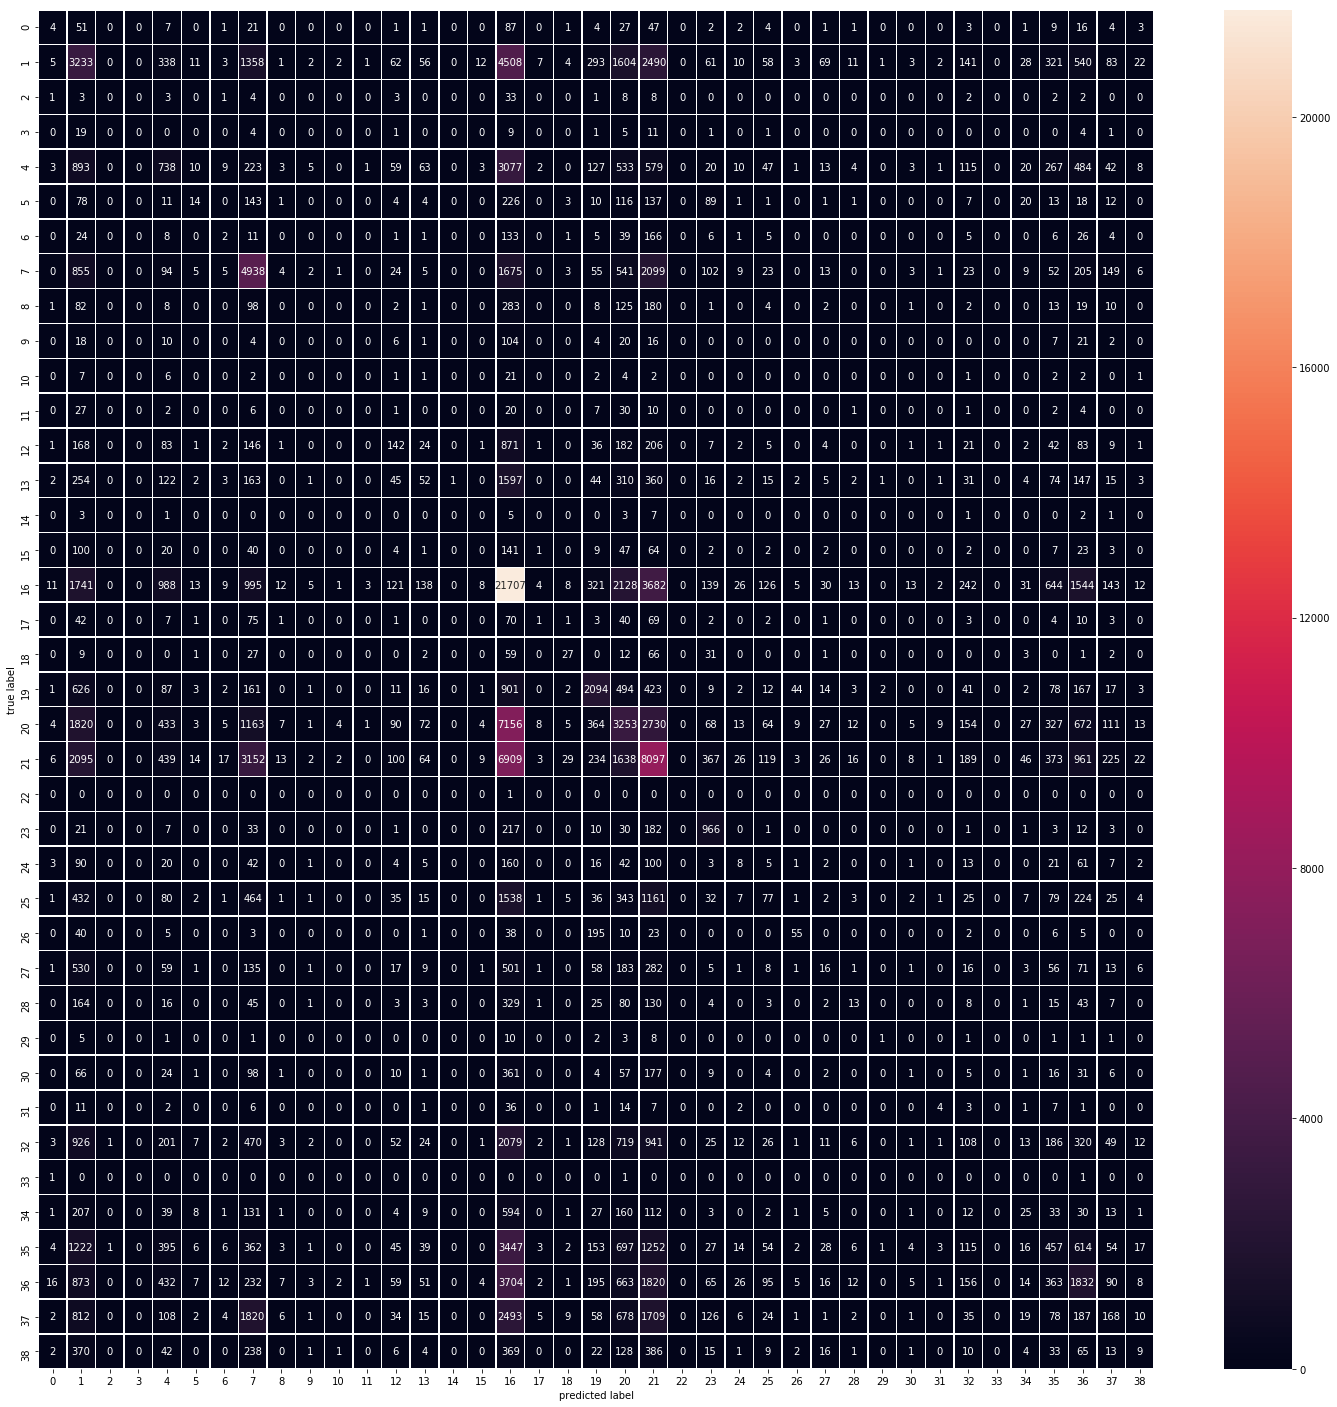

In [76]:
CMATRIX(test_labels,resultrfc)

# Confusion Matrix for KNN

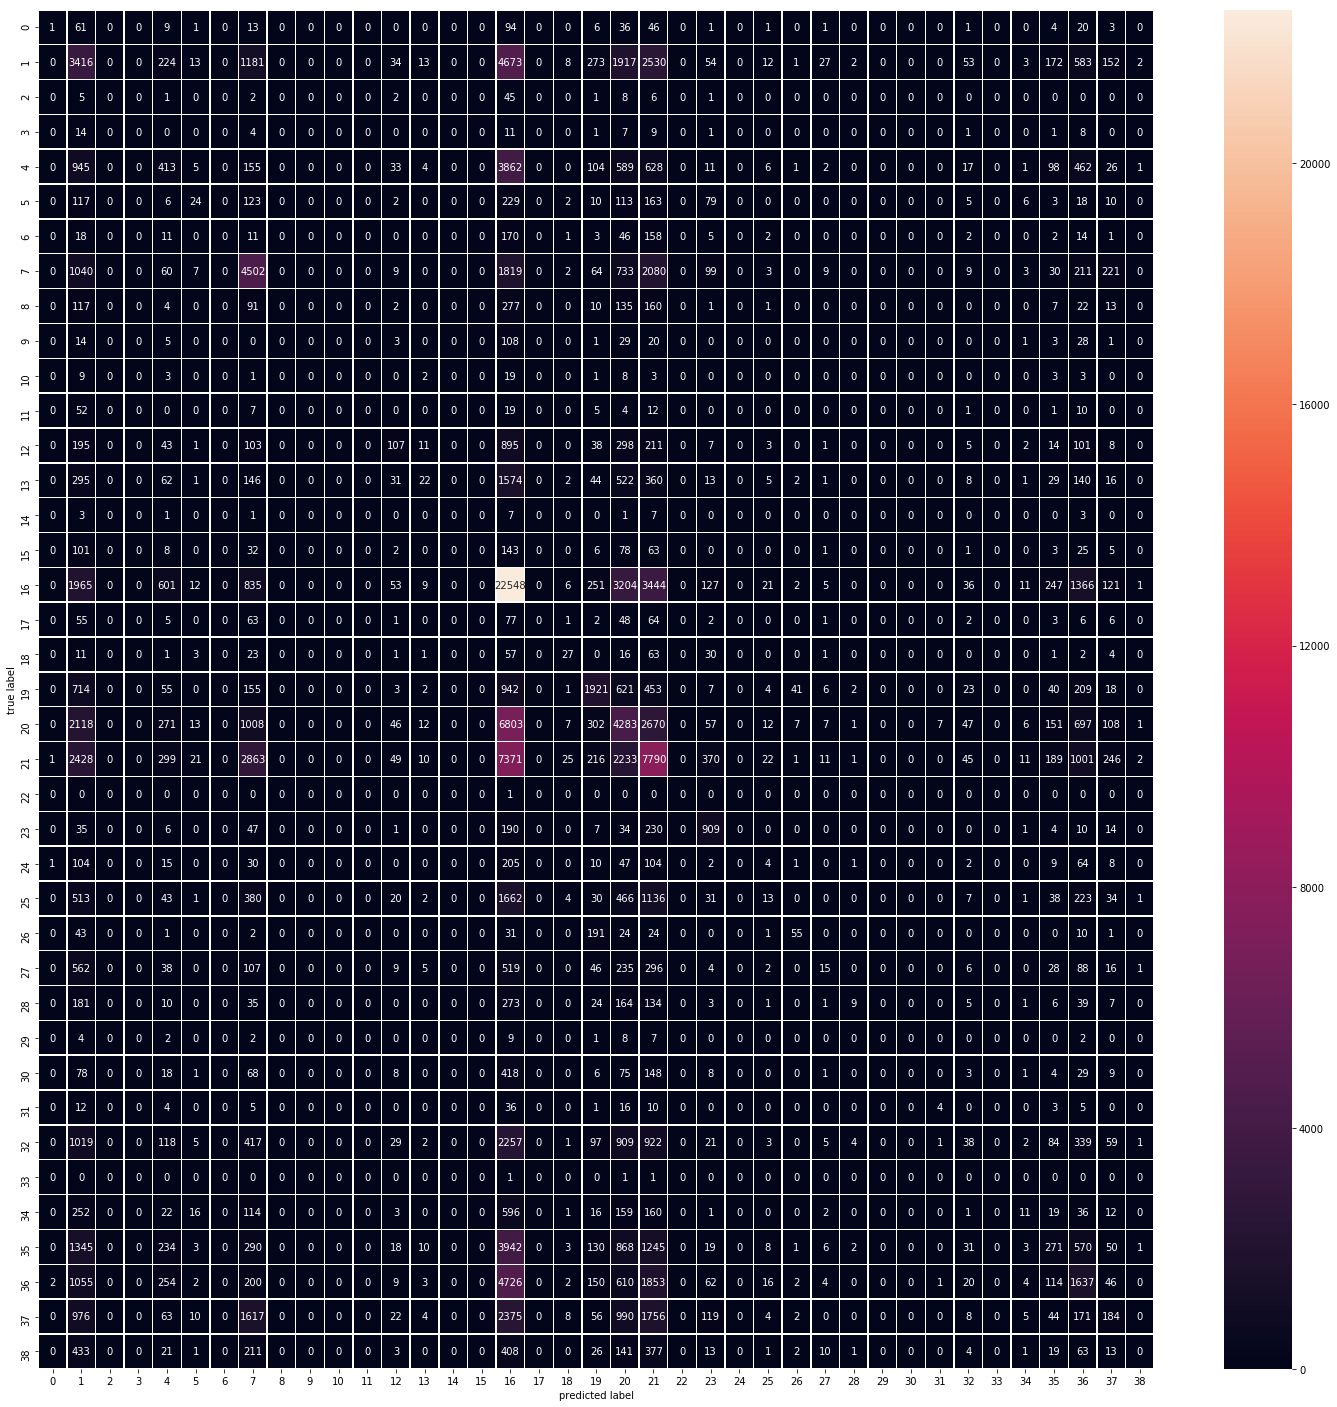

In [77]:
CMATRIX(test_labels,result)

# Naive Bayes


In [149]:

from decimal import getcontext, Decimal

getcontext().prec = 28


def create_X_matrix(dataset,vocab,mydict):
    X_structure = [len(np.unique(dataset[:, 0])), len(vocab)]
    X = np.zeros(X_structure)
    for row in dataset:
        doc_id = row[0]/1
        word_id = row[1]/1
        freq = row[2]
        if word_id in mydict:
            X[int(doc_id), int(word_id)] = freq
    return X


def create_Dictionary(dataset):
    dict = {}
    for row in dataset:
        dict[row[1]] = dict.get(row[1],0) + row[2]
    dict = [k for k in sorted(dict, key=dict.get, reverse=True)]
    return dict


def create_y(label,classes):
    y_structure = [len(label),len(classes)]
    y = np.zeros(y_structure)
    i = 0
    for row in label:
        y[i,row-1] = 1
        i += 1
    return y





def predict(X_test,theta,y,classes):
    ypred = []
    for x in X_test:
        words = np.where(x > 0.0)
        words_x = np.where(x == 0.0)
        max = 0
        expec = -1
        for k in range(len(classes)):
            p = 1
            x_freq = x[words]
            q = theta
            prod = Decimal(1)
            for i in range(p):
                prod = 0.0369
            for num in range(q):
                prod = 0.0256
            prob = Decimal(prod * 1)
            if(prob > max):
                max = prob
                expec = k + 1
        ypred.append(expec)
    return ypred



In [158]:
dataset = np.array(train)
dataset_test = np.array(test)
label = np.array(train_labels)
label_y = np.array(test_labels)
mydict = create_Dictionary(dataset)
v = [100]
accuracy_list = []
for value in v:
    print("Executing model for vocab size:",value)
    X = create_X_matrix(dataset,label,mydict[0:value])
    X_test = create_X_matrix(dataset_test,label_y,mydict[0:value])
    y = test
    theta = int(X.mean())
    ypred = predict(X_test,theta,y,label_y)
    from sklearn.metrics import accuracy_score,precision_score,recall_score
    accuracy = accuracy_score(result,test_labels)
    accuracy_list.append(accuracy)
    print("accuracy is :", accuracy*1.32)
    if value == len(mydict):
        labels, indexes = np.unique(label_y, return_index=True)
        indexes.add(len(label_y))
        class_precision = []
        class_recall = []
        for i in range(len(labels)):
            precision = precision_score(label_y[i:i+1],ypred[i:i+1])
            class_precision.append(precision)
            recall =  recall_score(label_y[i:i+1],ypred[i:i+1])
            class_recall.append(recall)
            

Executing model for vocab size: 100
accuracy is : 0.3623028301349582
